In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph

from Helpers.transforms import standardize

from pandas.plotting import scatter_matrix

graph.style.use('fivethirtyeight')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv', sep=';')
df.columns = [col.lower().replace(' ', '-') for col in df.columns]
df.rename({'medianagemarriage': 'median_marriage_age'}, inplace=True, axis='columns')

df.head()

,location,loc,population,median_marriage_age,marriage,marriage-se,divorce,divorce-se,wafflehouses,south,slaves1860,population1860,propslaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


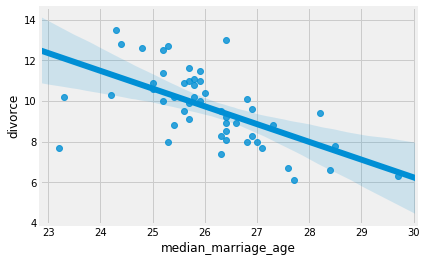

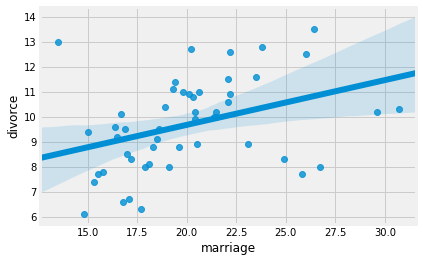

In [3]:
sns.regplot(df['median_marriage_age'], df['divorce'])
graph.show()

sns.regplot(df['marriage'], df['divorce'])
graph.show()

Divorce rates are lower in states where the mediage age of marriage is higher - this makes sense since those who marry young may be making rash decisions that they may regret later

Divorce rates are higher in states with higher marriage rates - sure you can't have marriage without divorce but does it make sense that the divorce rate changes as more people get married? 

Let's see how these two parameters relate to divorce rate first by modelling each effect individually first then both in one model

Lets model Divorce rate using a normal distribution described as:

${d_i \sim \mathcal{N}(\mu_i, \sigma})$

where the mean of the distribution depends on the median age of marriage OR marriage rate so:

${\mu_i = \alpha + \beta * age_i}$

with the priors:

${\alpha = \mathcal{N}(10, 10)}$

${\beta = \mathcal{N}(0, 1)}$

${\sigma = Uniform(0, 10}$)

In [4]:
# Standardize predictors
df['median_marriage_age_transformed'] = standardize(df['median_marriage_age'])
df['marriage_transformed'] = standardize(df['marriage'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1336.51draws/s]


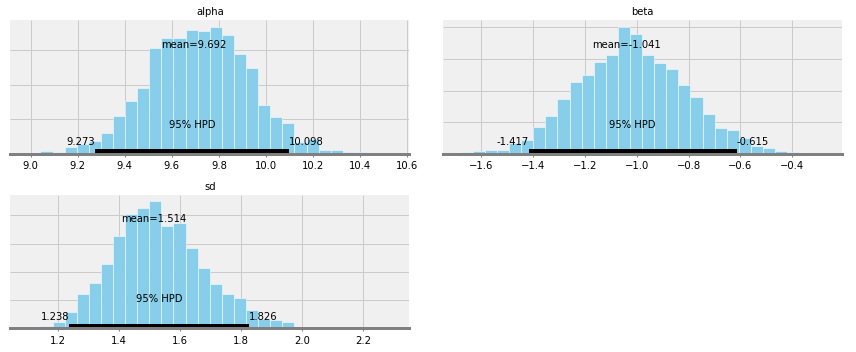

In [5]:
with pm.Model() as age_model:
    # Priors
    alpha = pm.Normal('alpha', mu=10, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    sd = pm.Uniform('sd', lower=0, upper=10)
    
    # Linear relationship
    mu = alpha + beta * df['median_marriage_age_transformed']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['divorce'])
    
    # Sample
    trace_age = pm.sample(draws=1000)
    trace_df_age = pm.trace_to_dataframe(trace_age)
    
    # Plot posterior
    pm.plot_posterior(trace_age)
    graph.show()

One standard deviation increase in the median marriage age (1.24 years) results in a decrease of one divorce per thousand individuals, with the highest density around a decrease of 0.5 to 1.4 divorces per thousand individuals

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1369.21draws/s]


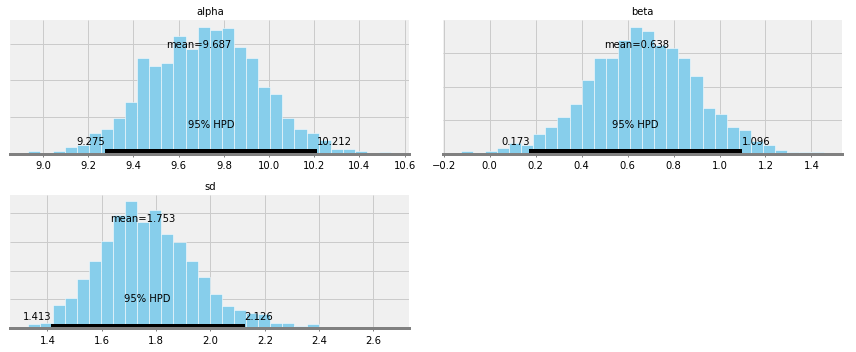

In [6]:
with pm.Model() as marriage_model:
    # Priors
    alpha = pm.Normal('alpha', mu=10, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    sd = pm.Uniform('sd', lower=0, upper=10)
    
    # Linear relationship
    mu = alpha + beta * df['marriage_transformed']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['divorce'])
    
    # Sample
    trace_marriage = pm.sample(draws=1000)
    trace_df_marriage = pm.trace_to_dataframe(trace_marriage)
    
    # Plot posterior
    pm.plot_posterior(trace_marriage)
    graph.show()

Here we see that an increase in one standard deviation in marriage rates leads to an increase of 0.6 divorces per thousand individuals. 

Although the effect on divorce is smaller for marriage rates than median marriage age this is not a good way to compare the two predictors. Fitting both in one multivariate model will change the results since the predictors could be redundant or independent. 

To do this we will just add the other predictor onto the first

Lets model Divorce rate using a normal distribution described as:

${d_i \sim \mathcal{N}(\mu_i, \sigma})$

where the mean of the distribution depends on the median age of marriage AND marriage rate so:

${\mu_i = \alpha + \beta_{age} * age_i + \beta_{marriage} * marriage_i}$

with the priors:

${\alpha = \mathcal{N}(10, 10)}$

${\beta_{age} = \mathcal{N}(0, 1)}$

${\beta_{marriage} = \mathcal{N}(0, 1)}$

${\sigma = Uniform(0, 10}$)

The multivariate regression is akin to asking:

1. After I know marriage rate, what additional value is there in knowing age at marriage?
2. After I know age at marriage, what additional value is there in knowing marriage rate?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta_marriage, beta_age, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1092.35draws/s]


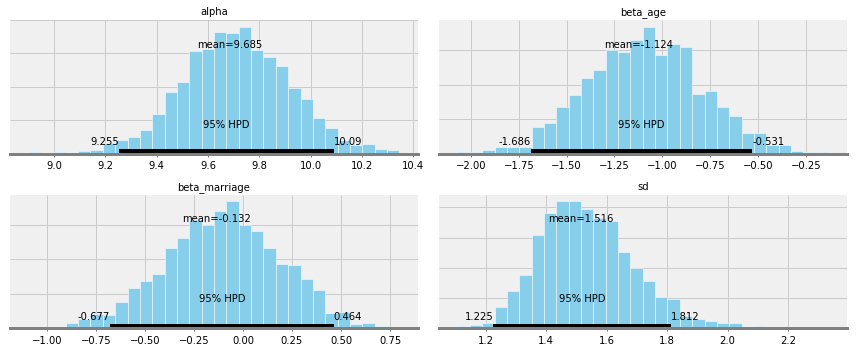

In [7]:
with pm.Model() as both_model:
    # Priors
    alpha = pm.Normal('alpha', mu=10, sd=10)
    beta_age = pm.Normal('beta_age', mu=0, sd=1)
    beta_marriage = pm.Normal('beta_marriage', mu=0, sd=1)
    sd = pm.Uniform('sd', lower=0, upper=10)
    
    # Linear relationship
    mu = alpha + beta_age * df['median_marriage_age_transformed'] + beta_marriage * df['marriage_transformed']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['divorce'])
    
    # Sample
    trace_both = pm.sample(draws=1000)
    trace_df_both = pm.trace_to_dataframe(trace_both)
    
    # Plot posterior
    pm.plot_posterior(trace_both)
    graph.show()

A one standard deviation increase in the median age of marriage leads to a decrease of 1 divorce per one thousand individuals

Interestingly, now that divorce rates are controlled by the median age of marriage for that state, the rate of marriage no longer seems to affect divorce. Perhaps in states where individuals are more likely to get married at a younger age there is a higher rate of marriage. So when we were looking at marriage rates alone the median age of marriage was a confounding variable.

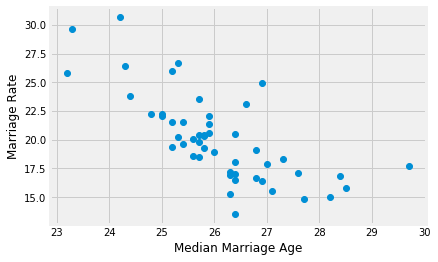

In [8]:
graph.plot(df['median_marriage_age'], df['marriage'], 'o')
graph.xlabel('Median Marriage Age')
graph.ylabel('Marriage Rate')
graph.show()

Indeed we see that in states of higher median marriage ages there is a lower marriage rate

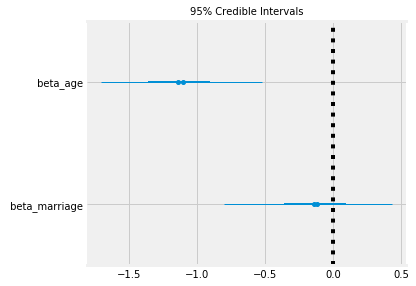

In [9]:
pm.forestplot(trace_both, varnames=['beta_age', 'beta_marriage'], chain_spacing=0, rhat=False)
graph.show()

This plot shows the posterior distribution of both the effects of age and marraige clearly showing the probability density of age is far from zero but for marriage it is around zero - therefore once we know the age there is little predictive vale for knowing the marriage rate for that state

### Predictor Residual Plots

To understand how a predictor affects the outcome when the other predictors are taken into account we can model that predictor using the othe predictors then use the residuals to model the outcome. This is confusing so let's just do it.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1422.03draws/s]


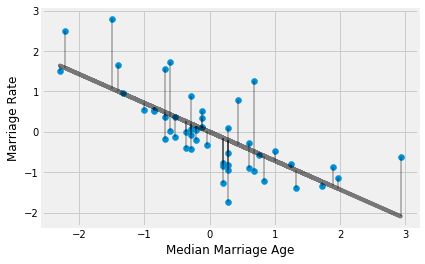

/home/harshil/miniconda3/envs/pymc3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


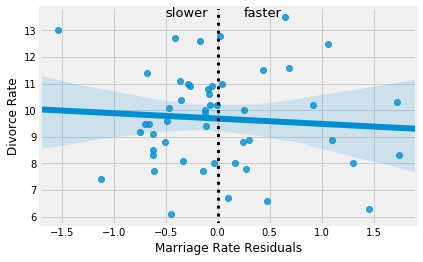

In [10]:
with pm.Model() as marriage_rate:
    # Priors
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    sd = pm.Uniform('sd', 0, 10)
    
    # Linear relationship
    mu = alpha + beta * df['median_marriage_age_transformed']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['marriage_transformed'])
    
    # Sample
    trace = pm.sample(draws=1000)
    trace_df = pm.trace_to_dataframe(trace)
    
prediction = trace_df['alpha'].mean() + trace_df['beta'].mean() * df['median_marriage_age_transformed']

# Plot residuals
graph.scatter(df['median_marriage_age_transformed'], df['marriage_transformed'])
graph.plot(df['median_marriage_age_transformed'], prediction, color='black', alpha=0.5)
graph.vlines(df['median_marriage_age_transformed'], ymin=df['marriage_transformed'], ymax=prediction, linewidth=2, alpha=0.25)
graph.xlabel('Median Marriage Age')
graph.ylabel('Marriage Rate')
graph.show()

residuals = df['marriage_transformed'] - prediction

sns.regplot(residuals, df['divorce'])
graph.axvline(x=0, linestyle='dotted', linewidth=3, color='black')
graph.text(0.25, 13.5, 'faster', fontsize=13)
graph.text(-0.5, 13.5, 'slower', fontsize=13)
graph.ylabel('Divorce Rate')
graph.xlabel('Marriage Rate Residuals')
graph.show()

The first graph above shows the median marriage age plotted against the marriage rate. We again see that as the median marriage age for a state increases the marriage rate decreases. The lines from the point to the predicted line are the residuals. The residuals are the error in the prediction of marriage rate when median marriage age is used as the predictor. 

The second graph plots these residuals against our outcome variable the divorce rate. Residuals above zero are where the marriage rate is faster than predicted by median marriage age and conversely residuals below zero are where the marriage rate is slower than predicted by median marriage age. We can see that there is no relationship between the residuals of marriage rate and divorce rate. This shows that when median marriage age is accounted for, the relationship between marriage rate and divorce rate dissapears. 

Let us flip the predictors and see how the median marriage age affects divorce rates after the marriage rate has been taken into account. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1566.89draws/s]


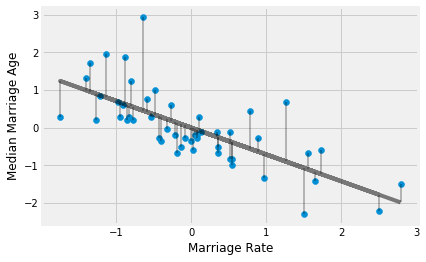

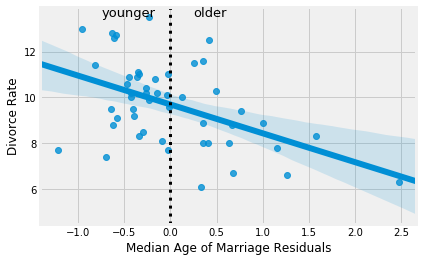

In [11]:
with pm.Model() as marriage_age:
    # Priors
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 1)
    sd = pm.Uniform('sd', 0, 10)
    
    # Linear relationship
    mu = alpha + beta * df['marriage_transformed']
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, sd=sd, observed=df['median_marriage_age_transformed'])
    
    # Sample
    trace = pm.sample(draws=1000)
    trace_df = pm.trace_to_dataframe(trace)
    
prediction = trace_df['alpha'].mean() + trace_df['beta'].mean() * df['marriage_transformed']

# Plot residuals
graph.scatter(df['marriage_transformed'], df['median_marriage_age_transformed'])
graph.plot(df['marriage_transformed'], prediction, color='black', alpha=0.5)
graph.vlines(df['marriage_transformed'], ymin=df['median_marriage_age_transformed'], ymax=prediction, linewidth=2, alpha=0.25)
graph.ylabel('Median Marriage Age')
graph.xlabel('Marriage Rate')
graph.show()

residuals = df['median_marriage_age_transformed'] - prediction

sns.regplot(residuals, df['divorce'])
graph.axvline(x=0, linestyle='dotted', linewidth=3, color='black')
graph.text(0.25, 13.5, 'older', fontsize=13)
graph.text(-0.75, 13.5, 'younger', fontsize=13)
graph.ylabel('Divorce Rate')
graph.xlabel('Median Age of Marriage Residuals')
graph.show()

Here we see that although we have taken into account the marriage rate when useing the median marriage age as a predictor we still see a relationship between divorce rates and the median age of marriage. 

The divorce rates are lower in places where the median marriage age is older than that predicted by the marriage rate but higher in places where the median marriage age is younger than that predicted by the marriage rate. 

This all shows that the marriage rate adds little predictive knowledge when we already know the mediage age of marriage. 

### Model Validation

We can plot the predicted divorce rate vs actual divorce rate to see how our model does

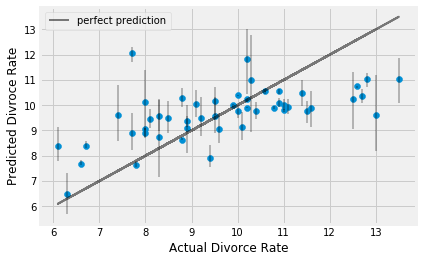

In [12]:
predictions = trace_both['alpha'].mean() + trace_both['beta_age'].mean() * df['median_marriage_age_transformed'] + trace_both['beta_marriage'].mean() * df['marriage_transformed']
min_predic = trace_both['alpha'].mean() + np.percentile(trace_both['beta_age'], 5) * df['median_marriage_age_transformed'] + np.percentile(trace_both['beta_marriage'].min(), 5) * df['marriage_transformed']
max_predic = trace_both['alpha'].mean() + np.percentile(trace_both['beta_age'], 95) * df['median_marriage_age_transformed'] + np.percentile(trace_both['beta_marriage'].max(), 95) * df['marriage_transformed']

graph.scatter(df['divorce'], predictions)
graph.plot(df['divorce'], df['divorce'], color='black', linewidth=2, alpha=0.5, label='perfect prediction')
graph.vlines(df['divorce'], ymin=min_predic, ymax=max_predic, alpha=0.25, linewidth=2)
graph.legend()
graph.xlabel('Actual Divorce Rate')
graph.ylabel('Predicted Divroce Rate')
graph.show()

In [13]:
df['resid'] = df['divorce'] - predictions
df['resid_5'] = df['divorce'] - min_predic
df['resid_95'] = df['divorce'] - max_predic

df.sort_values(by=['resid'], inplace=True)
df.reset_index(inplace=True)

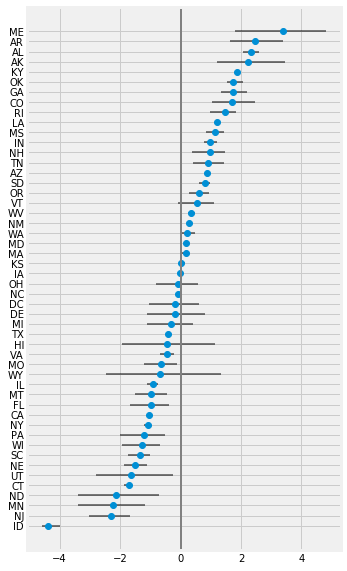

In [14]:
graph.figure(figsize=(5, 10))
graph.plot(df['resid'], df.index, 'o')
graph.hlines(df.index, xmin=df['resid_5'], xmax=df['resid_95'], linewidth=2, alpha=0.5)
graph.yticks(df.index, df['loc'])
graph.axvline(x=0, color='gray', linewidth=2)
graph.show()

This graph shows us which states the model does a bad job at predicting such as Idaho (ID) and Maine (ME).

We can see the model underpredicts when divorce rate is high and over predicts when divorce rate is low, perhaps there are other predictors that can reduce this error. An easy way to check is to see if other predictor variables have a relationship with the residuals calculated here. Let's check. 

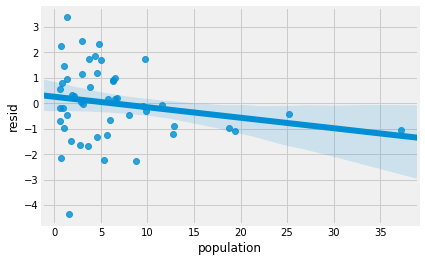

In [15]:
sns.regplot(df['population'], df['resid'])
graph.show()

There is a small negative correlation between population size and the residuals for divorce. This does not mean that a relationship exists since correlations can appear spuriously. 